In [1]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from sklearn import tree # for text representation
from matplotlib import pyplot as plt

import dtreeviz
from supertree import SuperTree
# import graphviz

#### data

In [8]:
segmentation_st = pd.read_sas("data_for_segmentation_st.sas7bdat")
segmentation_mw = pd.read_sas("data_for_segmentation_wi.sas7bdat")

In [28]:
segmentation_mw.columns

Index(['C_600570', 'C_660570', 'C_500300', 'C_500600', 'C_501200', 'C_502400',
       'C_111620', 'C_111640', 'C_111660', 'C_106860', 'C_106880', 'C_106920',
       'C_100100', 'C_100110', 'C_100120', 'C_100140', 'C_100160', 'C_104320',
       'C_100000', 'C_750100', 'C_750300', 'C_750600', 'C_751200', 'C_752400',
       'C_111500', 'C_650640', 'C_906170', 'C_930623', 'C_102800', 'C_106800',
       'C_106820', 'C_107480', 'C_110720', 'C_906370', 'C_912070', 'C_999032',
       'C_103380', 'C_106600', 'C_111300', 'C_111780', 'C_990370', 'C_114100',
       'C_600160', 'C_961223', 'C_105740', 'C_116000', 'C_990660', 'C_100900',
       'C_111600', 'C_114900', 'performance'],
      dtype='object')

#### bytes to strings

In [11]:
columns_to_convert = ["cbsmessageid","C_600570","C_660570","C_500300","C_500600","C_501200","C_502400","performance","Exclusion"]
def convert_bytes_to_str(x):
    return x.decode('utf-8') if isinstance(x, bytes) else x
segmentation_st[columns_to_convert] = segmentation_st[columns_to_convert].map(convert_bytes_to_str)
segmentation_mw[columns_to_convert] = segmentation_mw[columns_to_convert].map(convert_bytes_to_str)

In [12]:
segmentation_st = segmentation_st.drop(["cbsmessageid","Exclusion"],axis=1)
segmentation_mw = segmentation_mw.drop(["cbsmessageid","Exclusion"],axis=1)

#### NaN

In [16]:
original_dtypes = segmentation_mw.dtypes
imputer = SimpleImputer(strategy='most_frequent')
df_imp = pd.DataFrame(imputer.fit_transform(segmentation_mw), columns = segmentation_mw.columns)

In [18]:
df_imp = df_imp.astype(original_dtypes)

#### Encoding

In [20]:
label_encoders = {}
for column in df_imp.columns:
    if df_imp[column].dtype == 'object':
        le = LabelEncoder()
        df_imp[column] = le.fit_transform(df_imp[column])
        label_encoders[column] = le

#### Train, test split

In [23]:
X = df_imp.drop('performance', axis = 1)
y = df_imp['performance']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.3, random_state = 42)

#### Model - Decision Tree

In [25]:
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, random_state = 42, min_samples_leaf = 5_000)
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=5000,
                       random_state=42)

#### Visualisation

In [26]:
text_representation = tree.export_text(clf,
                                       feature_names = list(clf.feature_names_in_),
                                       show_weights = True)
print(text_representation)

# with open("decistion_tree.log", "w") as fout:
#     fout.write(text_representation)

|--- C_750100 <= 2.50
|   |--- C_111500 <= 0.50
|   |   |--- C_111300 <= 4.50
|   |   |   |--- weights: [7622.00, 267235.00] class: 1
|   |   |--- C_111300 >  4.50
|   |   |   |--- weights: [1162.00, 7391.00] class: 1
|   |--- C_111500 >  0.50
|   |   |--- C_111640 <= 0.50
|   |   |   |--- weights: [2252.00, 18881.00] class: 1
|   |   |--- C_111640 >  0.50
|   |   |   |--- weights: [2051.00, 6972.00] class: 1
|--- C_750100 >  2.50
|   |--- weights: [5513.00, 1101.00] class: 0



#### Tree plot

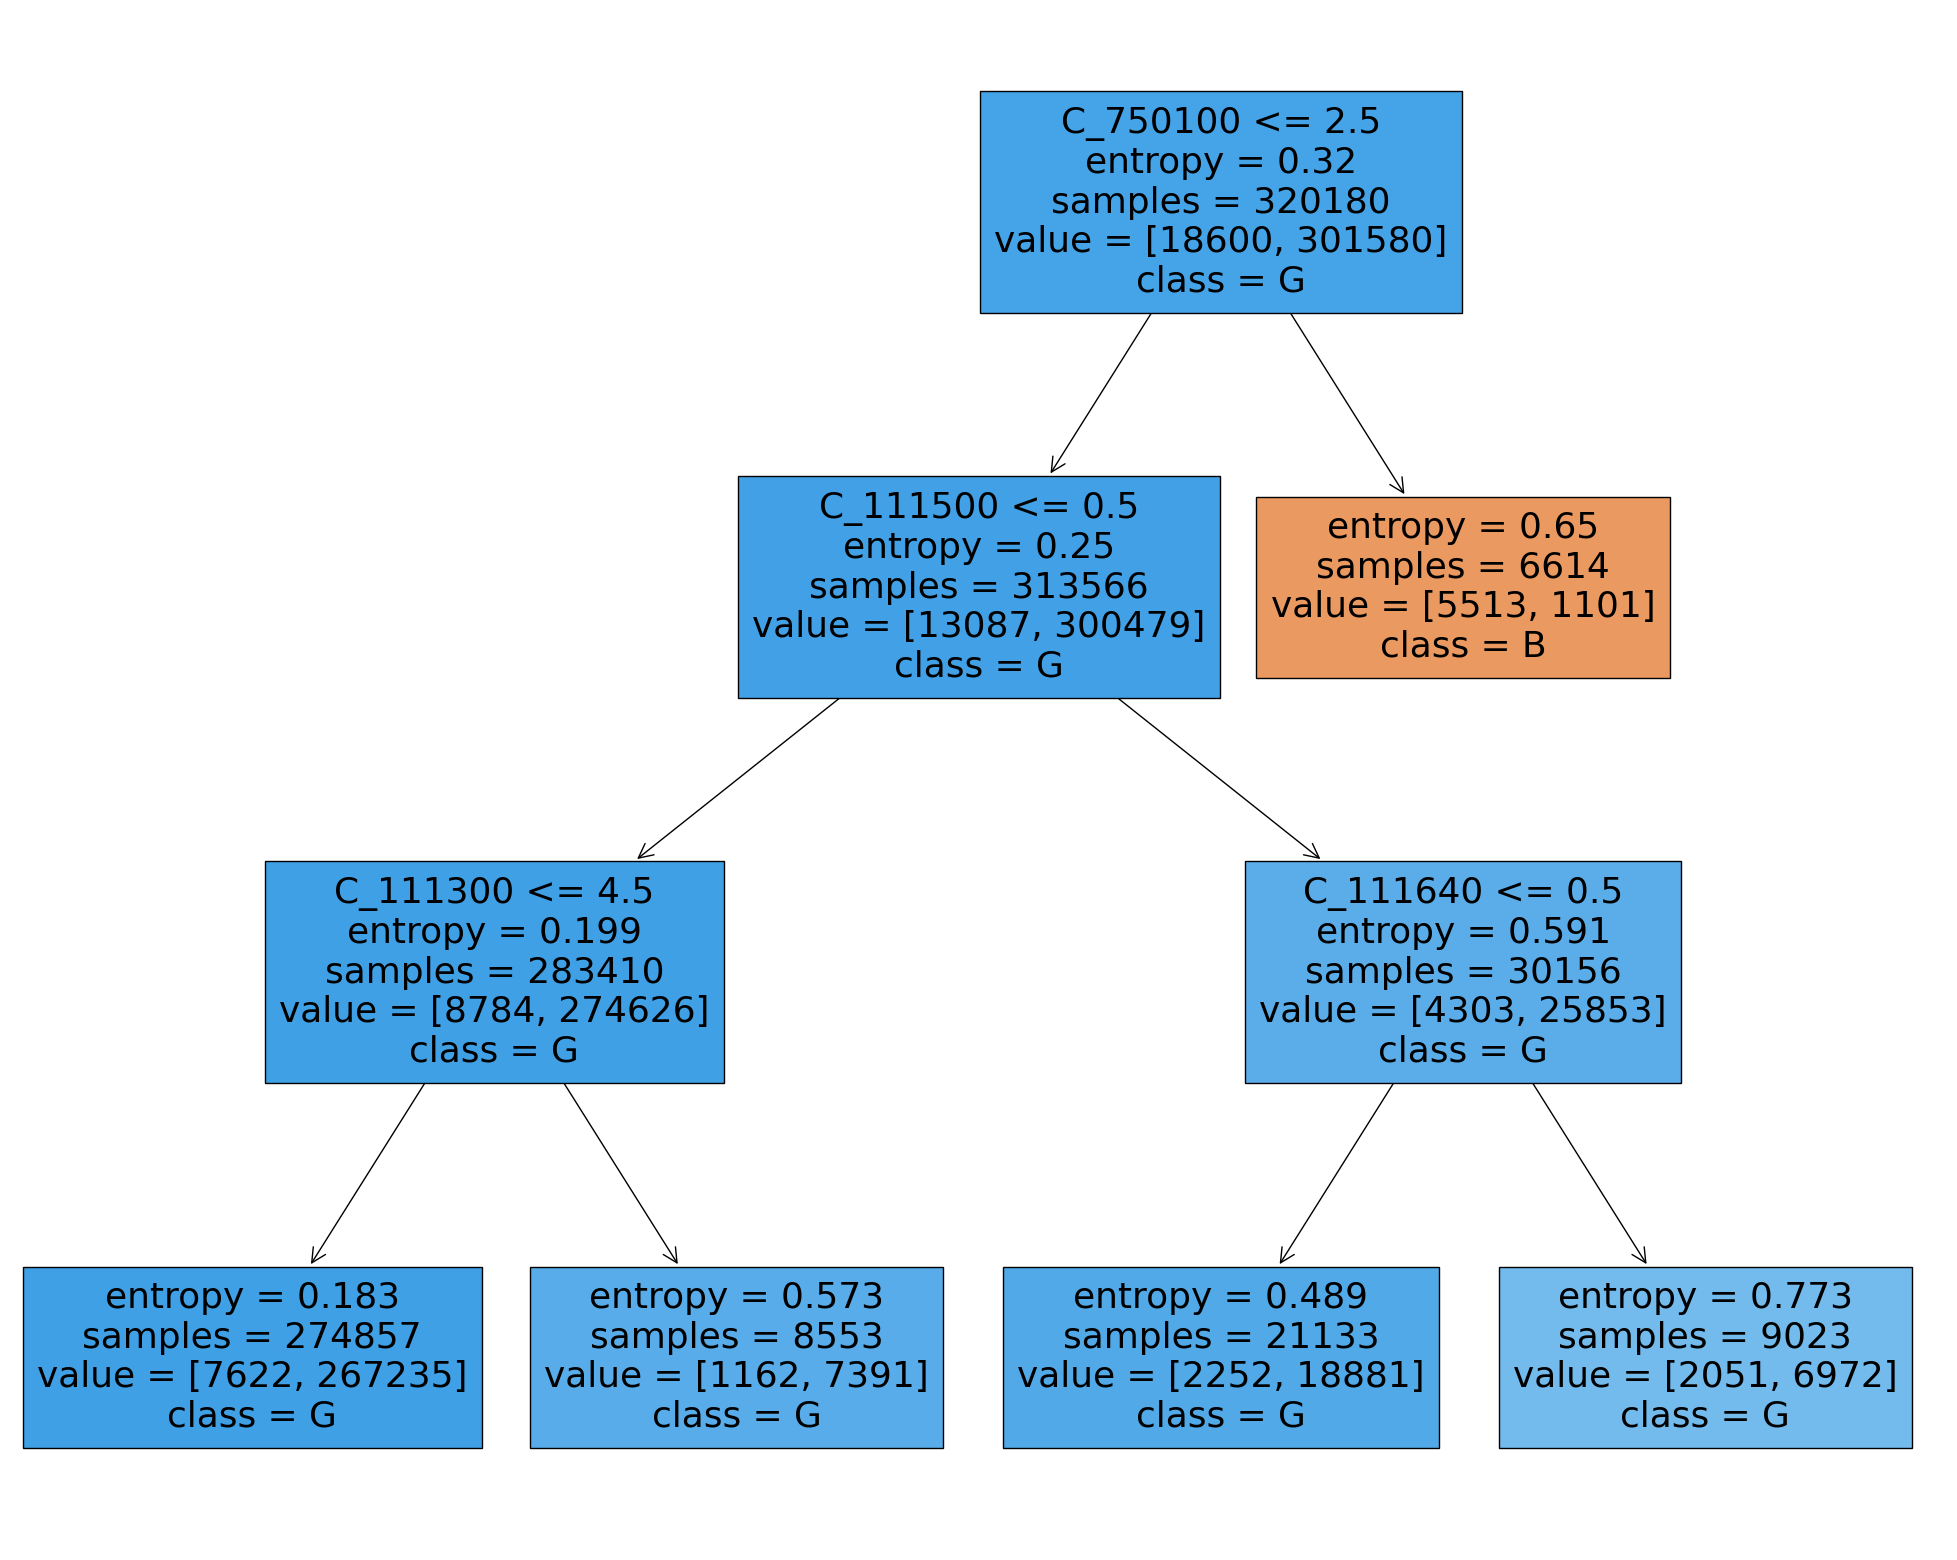

In [27]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf,
                   feature_names = list(clf.feature_names_in_),
                   class_names = ["B","G"],
                   filled = True)

# fig.savefig("decistion_tree.png")

#### Model - Random Forest

In [46]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns


In [43]:
rf = RandomForestClassifier(criterion = 'entropy', max_depth = 3, random_state = 42, min_samples_leaf = 5_000)
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=3, min_samples_leaf=5000,
                       random_state=42)

In [44]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
})

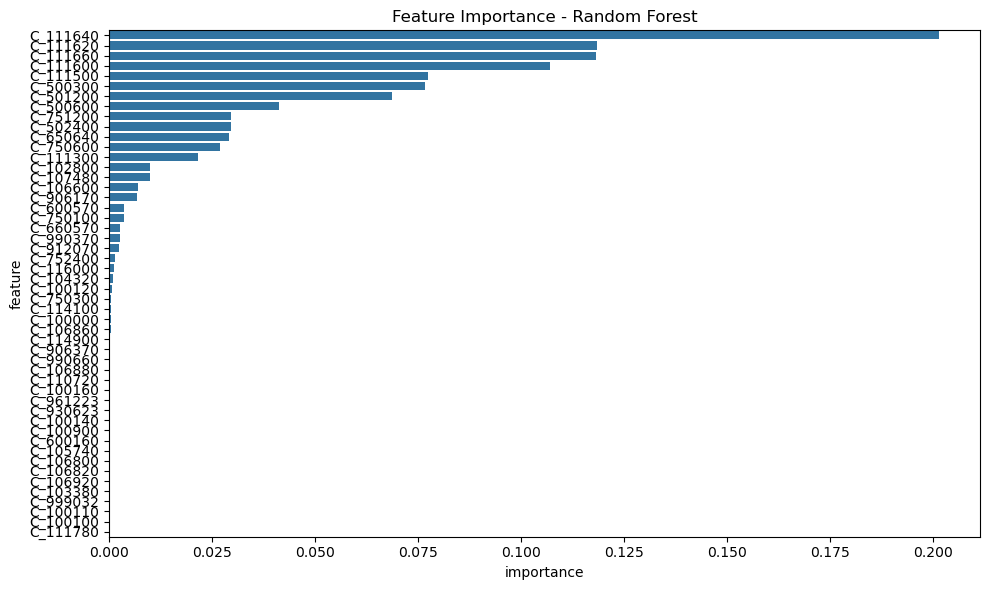

In [47]:
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Vizualizace
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

#### Feature importance based on mean decrease in impurity

In [48]:
importance = rf.feature_importances_

In [53]:
feature_names = X.columns

In [55]:
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

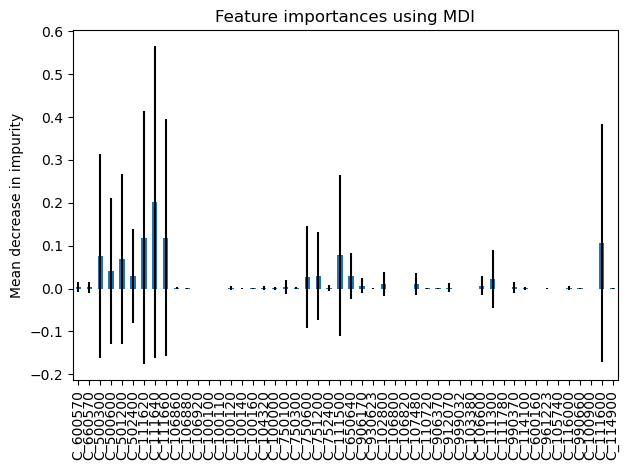

In [56]:
import matplotlib.pyplot as plt
forest_importances = pd.Series(importance, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Feature importance based on feature permutation

In [58]:
from sklearn.inspection import permutation_importance


In [59]:
result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

In [60]:
forest_importances = pd.Series(result.importances_mean, index=feature_names)

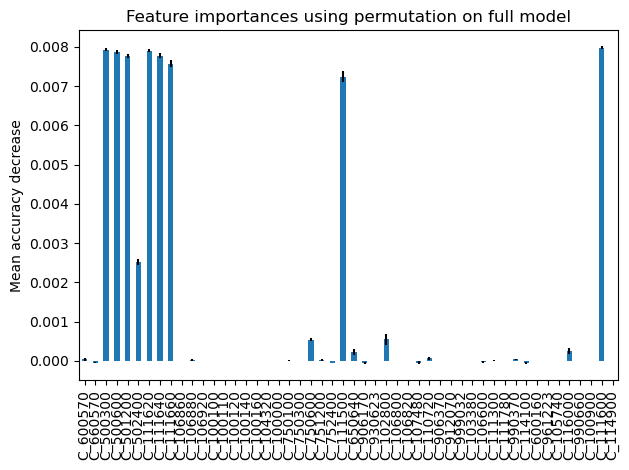

In [61]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()